In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from global_land_mask import globe
import scipy.stats as stats

In [2]:
# Load datasets
dataset_path = '/data/fast1/surface-load/'
ds = xr.open_dataset(dataset_path + "GRCTellus.JPL.200204_202102.GLO.RL06M.MSCNv02CRI.nc")

In [3]:
ds

<xarray.Dataset>
Dimensions:        (bounds: 2, lat: 360, lon: 720, time: 194)
Coordinates:
  * lon            (lon) float64 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8
  * lat            (lat) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * time           (time) datetime64[ns] 2002-04-17T12:00:00 ... 2021-02-15
Dimensions without coordinates: bounds
Data variables:
    lwe_thickness  (time, lat, lon) float64 ...
    uncertainty    (time, lat, lon) float64 ...
    lat_bounds     (lat, bounds) float64 ...
    lon_bounds     (lon, bounds) float64 ...
    time_bounds    (time, bounds) datetime64[ns] ...
Attributes: (12/53)
    Conventions:                   CF-1.6, ACDD-1.3, ISO 8601
    Metadata_Conventions:          Unidata Dataset Discovery v1.0
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    title:                         JPL GRACE and GRACE-FO MASCON RL06Mv2 CRI
    summary:                       Monthly gravity solutions from GRACE and G...
    keywords:                      Solid Earth, Geodetics/Gravity, Gravity, l...
    ...                            ...
    C_30_substitution:             TN-14; Loomis et al., 2019, Geophys. Res. ...
    user_note_1:                   The accelerometer on the GRACE-B spacecraf...
    user_note_2:                   The accelerometer on the GRACE-D spacecraf...
    journal_reference:             Watkins, M. M., D. N. Wiese, D.-N. Yuan, C...
    CRI_filter_journal_reference:  Wiese, D. N., F. W. Landerer, and M. M. Wa...
    date_created:                  2021-03-30T09:03:16Z

Text(0, 0.5, 'Surface load (mm water equiv.)')

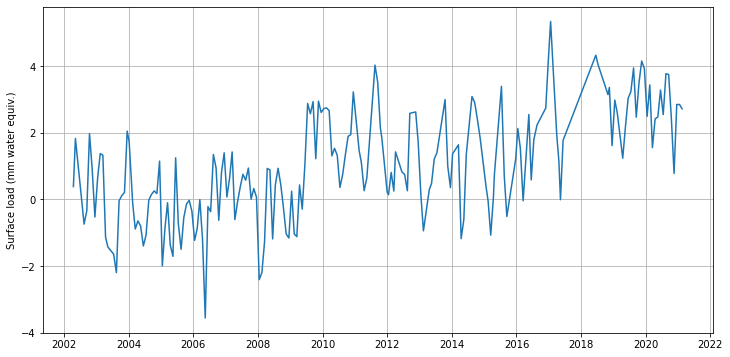

In [16]:
seattle = ds.isel(lat=47, lon=-122)
plt.subplots(figsize=(12,6))
plt.plot(seattle.time,seattle.lwe_thickness)
plt.grid()
plt.ylabel('Surface load (mm water equiv.)')

In [68]:
number_of_time_steps = len(ds.time)
data_matrix = np.zeros((360*720,number_of_time_steps))

for i in range(number_of_time_steps):
    this_data = ds.isel(time=i).lwe_thickness
#     print(this_data.values.flatten().shape)
    data_matrix[:,i] = this_data.values.flatten()
    
#     fig,ax = plt.subplots(figsize=(12,12))
#     globe_2010.plot(vmin=-10,vmax=10)


The Singular Value Decomposition writes a matrix D as

D = U * S * V

In [76]:
from scipy.sparse.linalg import svds
u,s,v = svds(data_matrix,k=7)

In [77]:
u.shape

(259200, 7)

In [78]:
s.shape

(7,)

In [79]:
v.shape

(7, 194)

In [103]:
which_mode = 6

first_left_singular_vector = np.reshape(u[:,which_mode],this_data.values.shape)
first_right_singular_vector = v[which_mode,:]
print(first_left_singular_vector.shape)
print(first_right_singular_vector.shape)

(360, 720)
(194,)


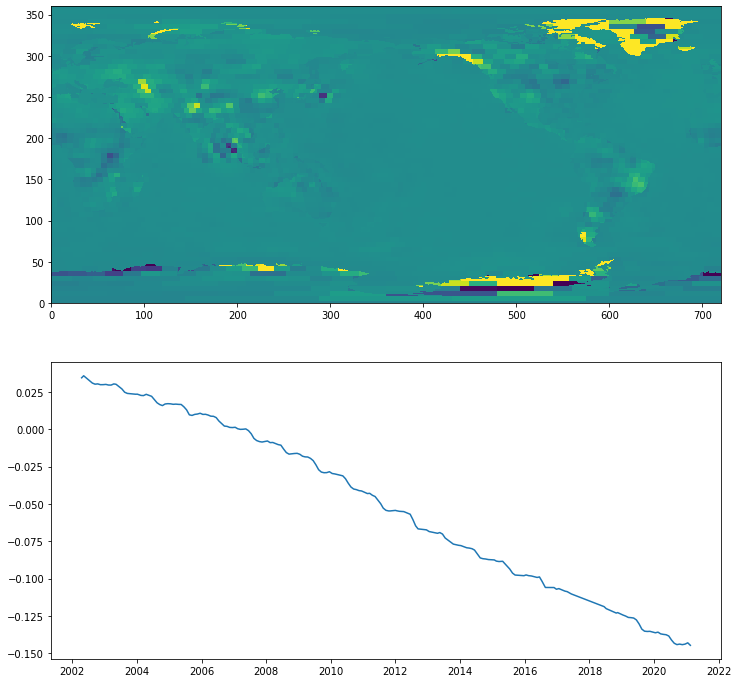

In [104]:
plt.subplots(2,1,figsize=(12,12))
plt.subplot(2,1,1)
plt.pcolor(first_left_singular_vector,vmin=-0.005,vmax=0.005)
plt.subplot(2,1,2)
plt.plot(ds.time,first_right_singular_vector)

<BarContainer object of 7 artists>

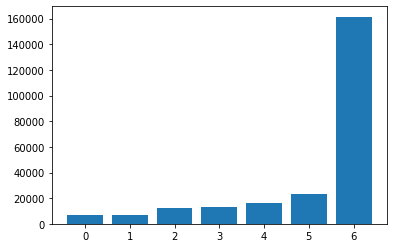

In [99]:
plt.bar(range(len(s)),s)

In [100]:
s

array([  6618.979566  ,   7246.31299666,  12092.53326692,  12810.95678694,
        16579.71881291,  22979.22477239, 161493.29184373])